# START HERE

In [313]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten,\
BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import pickle
import splitfolders

In [314]:
def fetch_files_names(directory):
    subfolders_path = [ f.name for f in os.scandir(directory) if f.is_dir() ]
    return subfolders_path

In [319]:
# directory of the base folder
dir = 'data/set_of_10/'
# Create a dictionary with mashrooms and labels TAKEN FROM KAGGLE PARTITION
CLASSES = {'Mycena_galericulata': 0,
 'Trametes_versicolor': 1,
 'Plicatura_crispa': 2,
 'Tremella_mesenterica': 3,
 'Hypholoma_fasciculare': 4,
 'Pluteus_cervinus': 5,
 'Meripilus_giganteus': 6,
 'Pleurotus_ostreatus': 7,
 'Russula': 8,
 'Stereum_hirsutum': 9}

In [320]:
# give the directory that includes folders of images and return three files split in train test validation

def split_data(dir = dir, output = dir + "/../output"):
    """
    Split data in train, test, validataion
    """
    splitfolders.ratio(dir , output=output, seed=1337, ratio=(.75, 0.15,0.1)) 


In [321]:
split_data()
train_path = dir + "/../output" + '/train/'
test_path = dir + "/../output" + '/test/'
valid_path = dir + "/../output" + '/val/'

Copying files: 11550 files [00:54, 213.61 files/s]


In [322]:
# prepare data for the model in batches to avoid RAM problems
train_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2) 

train_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=CLASSES, batch_size=64,subset='training',)

validation_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=CLASSES, batch_size=64,subset='validation',)

test_batches = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(\
directory=test_path, target_size=(224,224), classes=CLASSES, \
batch_size=64, shuffle=False,)


Found 8636 images belonging to 10 classes.
Found 2154 images belonging to 10 classes.
Found 2184 images belonging to 10 classes.


# MODEL ResNet50V2

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_ResNet50V2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = ResNet50V2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_ResNet50V2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/ResNet50V2.h5') 
    return model, history


In [ ]:
model = model_ResNet50V2(learning_rate=0.001)
model, history = fit_ResNet50V2(epochs = 200)

In [ ]:
# Model MobileNetV2
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_MobileNetV2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = MobileNetV2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_MobileNetV2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/MobileNetV2.h5') 
    return model, history


In [ ]:
model = model_MobileNetV2(learning_rate=0.001)
model, history = fit_MobileNetV2(epochs = 200)

# EfficientNetB7

In [386]:
# Model MobileNetV2
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_InceptionResNetV2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = InceptionResNetV2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_InceptionResNetV2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/InceptionResNetV2_test.h5') 
    return model, history


In [ ]:
model = model_InceptionResNetV2(learning_rate=0.001)
model, history = fit_InceptionResNetV2(epochs = 200)

# Evaluate model

In [327]:
def plot_history(history):
    losses_accurs = pd.DataFrame(history)
    
    losses_accurs[['loss', 'val_loss']].plot()
    plt.title('Train and Test (val) Loss')
    plt.xlabel('epochs')
    plt.show()

    losses_accurs[['categorical_accuracy', 'val_categorical_accuracy']].plot()
    plt.title('Train and Test (val) Accuracy')
    plt.xlabel('epochs')
    plt.show()

In [346]:
def evaluate(model_dir):
    model=keras.models.load_model("models/" + model_dir + ".h5")
    history = pd.read_csv('models/history_' + model_dir + '.csv')
    plot_history(history)
    acc = history.tail(1)
    print(f"The model has an accuracy of {int(round(acc['val_categorical_accuracy'].values[0],2)*100)} %.")
    return history, acc, model
    

In [368]:
import seaborn as sns
import matplotlib.pyplot as plt

losses_accurs = pd.DataFrame(history)
losses_accurs['model'] = 1
losses_accurs['count'] = np.arange(0,len(losses_accurs))

losses_accurs1 = pd.DataFrame(history1)#.rename(columns={'y2': 'y1'})
losses_accurs1['model'] = 2
losses_accurs1['count'] = np.arange(0,len(losses_accurs1))
losses_accurs1
losses_accurs
df = pd.concat([losses_accurs, losses_accurs1 ]).reset_index(drop=True)
df.head()

,Unnamed: 0,loss,categorical_accuracy,val_loss,val_categorical_accuracy,model,count
0,0,2.133448,0.237017,1.826895,0.431134,1,0
1,1,1.676621,0.426717,1.389317,0.560185,1,1
2,2,1.371500,0.523370,1.171571,0.613426,1,2
3,3,1.186611,0.582516,1.049890,0.653356,1,3
4,4,1.057412,0.636180,0.970758,0.670139,1,4


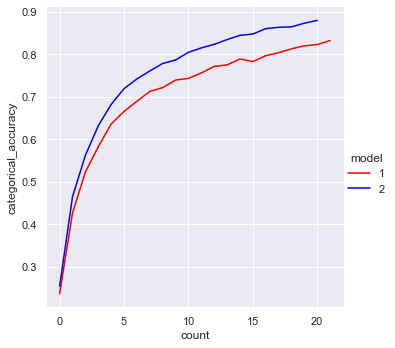

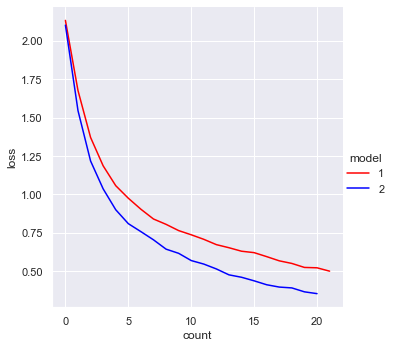

In [373]:
#data=df.melt(id_vars=["x-axis", "group", "group2"], value_vars=["col1", "col2"])
sns.relplot(data=df, x = 'count', y = 'categorical_accuracy', kind = 'line', hue = 'model', palette = ['red', 'blue'])
sns.relplot(data=df, x = 'count', y = 'loss', kind = 'line', hue = 'model', palette = ['red', 'blue'])


/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


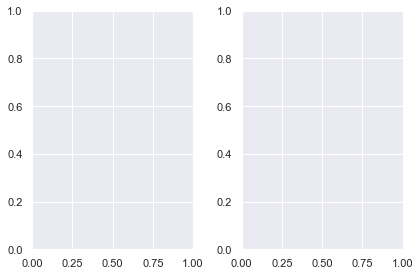

In [382]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0]
axs[1].plot(x, -y)
g1 = sns.relplot(data=df, x = 'count', y = 'categorical_accuracy',  hue = 'model',style='model',palette=['red', 'blue'], ax=ax[0])
g2 = sns.relplot(data=df, x = 'count', y = 'loss',  hue = 'model',style='model',palette=['green', 'black'], ax=ax[1])
plt.close(g1.fig)
plt.close(g2.fig) 
plt.tight_layout()

<AxesSubplot:xlabel='count', ylabel='categorical_accuracy'>

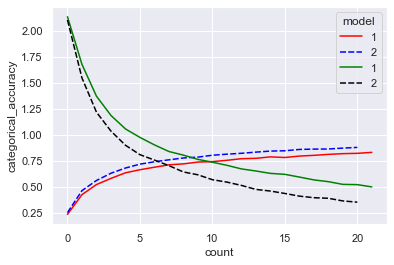

In [378]:
sns.lineplot(data=df, x = 'count', y = 'categorical_accuracy',  hue = 'model',style='model',palette=['red', 'blue'])
sns.lineplot(data=df, x = 'count', y = 'loss',  hue = 'model',style='model',palette=['green', 'black'])


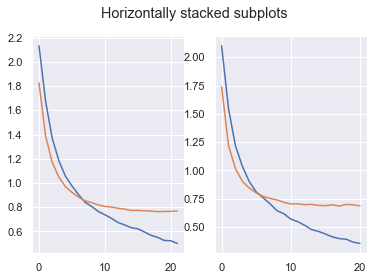

In [383]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(losses_accurs[['loss', 'val_loss']])
ax2.plot(losses_accurs1[['loss', 'val_loss']])

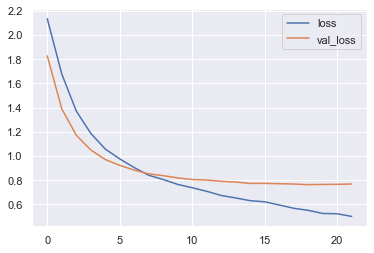

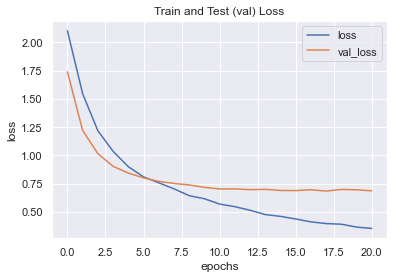

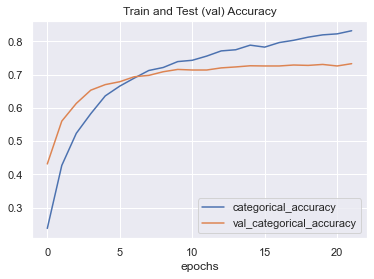

In [353]:
# test comparing models
losses_accurs = pd.DataFrame(history)
losses_accurs1 = pd.DataFrame(history1)
losses_accurs[['loss', 'val_loss']].plot()
losses_accurs1[['loss', 'val_loss']].plot()
plt.title('Train and Test (val) Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
losses_accurs[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title('Train and Test (val) Accuracy')
plt.xlabel('epochs')
plt.show()

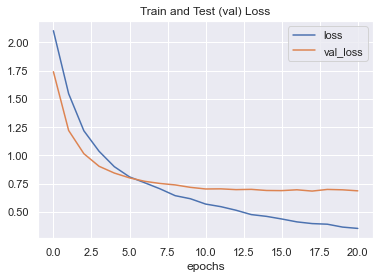

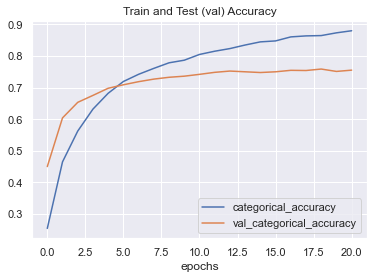

The model has an accuracy of 76 %.


In [352]:
history1, acc1, model1 = evaluate('MobileNetV2_3la_0001r_60bs_10set')

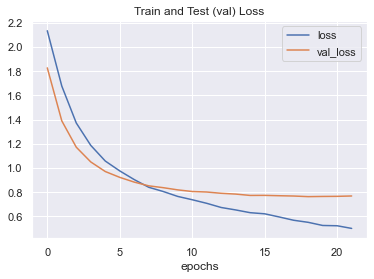

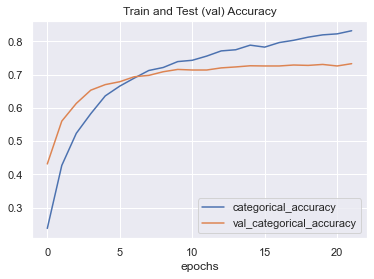

The model has an accuracy of 73 %.


In [347]:
history, acc, model = evaluate('MobileNetV2_2la_0001r_60bs_10set')


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# you could either use this custom function or the built in function from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

In [ ]:
test_batches = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(\
directory=test_path, target_size=(224,224), classes=['cats', 'dogs'], \
batch_size=64, shuffle=False)

# Prediction

In [348]:
def fetch_image(subdirectory):
    onlyfiles = [f for f in listdir(subdirectory) if isfile(join(subdirectory, f))]
    #label = np.full((1, len(onlyfiles)), get_label(onlyfiles))#.ravel()
    return onlyfiles

In [349]:
def image_classification(image_path, model):
    image = keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    pic_array = keras.preprocessing.image.img_to_array(image)
    image_batch = np.expand_dims(pic_array, axis=0)
    processed_image = keras.applications.mobilenet_v2.preprocess_input(image_batch)
    probs = model.predict(processed_image)[0].tolist()
    zipped = sorted(list(zip(CLASSES, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df


In [350]:
def choose_test_file(direct = 'data/test/', model = model):
    image_dir = direct + random.choice(os.listdir(direct))
    item = cv2.imread(image_dir)
    plt.imshow(item,cmap='Greys')
    return image_classification(image_dir, model)
    


,image_class,probability(%)
0,Plicatura_crispa,99.021423
1,Mycena_galericulata,0.336752
2,Stereum_hirsutum,0.334154
3,Hypholoma_fasciculare,0.128831
4,Trametes_versicolor,0.105542
5,Pleurotus_ostreatus,0.031275
6,Pluteus_cervinus,0.018670
7,Tremella_mesenterica,0.012154
8,Meripilus_giganteus,0.006672
9,Russula,0.004522


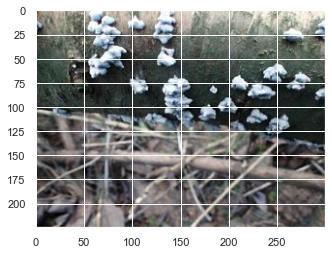

In [351]:
choose_test_file()